# CX 4230, Spring 2016: [36] Dynamical systems on networks

## (Sample solutions)

This lab accompanies the slides from the last class: https://t-square.gatech.edu/access/content/group/gtc-59b8-dc03-5a67-a5f4-88b8e4d5b69a/cx4230-sp16--34--dyn-sys-nets.pdf

## A conceptual model of "opinion dynamics"

To illustrate the interesting dynamics possible on a network, we'll look at an example considered by [Pluchino et al. (2005)](http://arxiv.org/abs/cond-mat/0410217v2). They were interested in the following question about a network of interacting agents:

> Can agents with different intitial states converge to one or a few uniform states?

They were especially interested in a social network of people where the "states" are differing opinions: if everyone has a different opinion initally, can they still reach agreement? They were inspired by biological systems, like [synchronizing fireflies](https://www.youtube.com/watch?v=a-Vy7NZTGos). For more fun background on this topic, see this TED talk by Steven Strogatz: https://www.youtube.com/watch?v=aSNrKS-sCE0

In Pluchino et al.'s mathematical model, they considered $x_i \equiv x_i(t) \in \mathcal{R}$ to be some measure of the "opinion" of person $i$. It can be positive or negative, and it can take any value in $(\infty, \infty)$. These people are connected in a social network, represented as an undirected graph given by its adjacency matrix, $A \equiv (a_{ij})$, where $a_{ij} = 1$ if persons $i$ and $j$ are connected, and 0 otherwise.

They hypothesized a model of the dynamics of $x_i(t)$ by the system of ODEs,

$$\dfrac{dx_i}{dt} \equiv f_i(\vec{x}) \equiv w_i + \dfrac{K}{d_i} \sum_j a_{ij} \cdot \sin \theta_{ij} \cdot \exp \left( -\alpha \cdot \theta_{ij}^2 \right),$$

where $K$ and $\alpha$ are model parameters, $d_i$ is the degree (number of neighbors) of $i$, and $\theta_{ij} \equiv x_j - x_i$, that is, the difference between the opinions of person $i$ and $j$. This formula expresses several modeling ideas.

One idea is that there is a person-specific rate of change, $w_i$. They took $w_i$ in a population to be randomly distributed; in this notebook, let's assume a normal distribution with some prescribed variance $\sigma^2$, so that $w_i \sim \mathcal{N}(0, \sigma^2)$.

The other ideas are about how the interaction between a pair $(i, j)$ of _connected_ people (i.e., $a_{ij} = 1$), expressed relative to their difference, $\theta_{ij}$. Consider small positive values of $theta_{ij}$, meaning person $j$ feels a little more positively than person $i$; then $\sin \theta_{ij}$ will be positive and thus influencing the change in person $i$'s opinion to be more positive. Then, at a certain point ($\theta_{ij} = \pi$), the two differ by enough that they start to polarize ($\sin \theta_{ij} < 0$). These oscillations continue for still larger $\theta_{ij}$. However, the oscillatory behavior is moderated by the difference, as expressed in the $\exp \left( -\alpha \cdot \theta_{ij}^2 \right)$ term: the farther the difference the less the influence. The interactions are summed across all neighbors $j$. Lastly, there is a final normalizing factor consisting of a parameter $K$ and normalization by the number of neighbors, or degree, $d_i$.

Lastly, observe that the $a_{ij}$ in the sum acts as a filter, including contributions only from $\theta_{ij}$ where $a_{ij} \neq 0$. Let's use this fact to simplify the notation of the system accordingly. Let

* $\vec{w} \equiv (w_i)$ be the vector of person-specific change rates;
* $D \equiv \mbox{diag}(d_i)$ be the _diagonal_ matrix of degrees;
* $\Theta \equiv (\theta_{ij})$ be the matrix of all pairwise differences;
* $A \odot B$ denote elementwise multiplication of matrices $A$ and $B$; and
* $\vec{u} \equiv (1, ..., 1)^T$ be the vector of all ones.

The the (sparse) matrix of _filtered_ pairwise differences is $\hat{\Theta} \equiv A \odot \Theta$.

Now the entire system of ODEs can be written as,

$$
  \dfrac{d\vec{x}}{dt} = \vec{f}(\vec{x}) = \vec{w} + K D^{-1} \cdot \sin (\hat{\Theta}) \cdot \exp (-\alpha \cdot \hat{\Theta} \odot \hat{\Theta}) \cdot \vec{u}.
$$

## Implementing the model: Preliminaries

In [1]:
import numpy as np
import scipy as sp
import scipy.sparse
from scipy.integrate import odeint
import math

In [2]:
# Core plotting support
import matplotlib.pyplot as plt
%matplotlib inline

For simplicity, let's assume a 2-D grid graph, that is, the graph that is an $n \times n$ lattice of nodes, where each node is connected to its 8 nearest neighbors. The following code cell downloads a handy module that helps construct the matrix $A$ corresponding to this graph.

In [3]:
import os ; os.makedirs ('cx4230', exist_ok=True)

# http://stackoverflow.com/questions/7243750/download-file-from-web-in-python-3
import urllib.request
MOD_URL = 'https://github.com/rvuduc/cx4230-ipynbs/raw/master/cx4230/pyamg_stencil.py'
MOD_LOCAL = 'cx4230/pyamg_stencil.py'
urllib.request.urlretrieve (MOD_URL, MOD_LOCAL)

%reload_ext autoreload
%autoreload 2

from cx4230 import pyamg_stencil
from cx4230.pyamg_stencil import stencil_grid

In [97]:
# Demo
def gen_grid_graph (n):
    S_2d_8nn = np.array ([[1, 1, 1],
                          [1, 0, 1],
                          [1, 1, 1]])
    return stencil_grid (S_2d_8nn, (n, n)).tocsr ()

n = 4
A_2d = gen_grid_graph (n)

print (A_2d.shape)
print (A_2d.todense ())

(16, 16)
[[0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0]
 [1 1 1 0 1 0 1 0 1 1 1 0 0 0 0 0]
 [0 1 1 1 0 1 0 1 0 1 1 1 0 0 0 0]
 [0 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 0]
 [0 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0]
 [0 0 0 0 0 1 1 1 0 1 0 1 0 1 1 1]
 [0 0 0 0 0 0 1 1 0 0 1 0 0 0 1 1]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0]
 [0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0]]


Given an arbitrary binary adjacency matrix for an undirected graph, the following function computes the degree of each node.

In [98]:
def degrees (A):
    return np.squeeze (np.asarray (sum (A).todense ()))

# Demo
np.reshape (degrees (A_2d), (n, n))

array([[3, 5, 5, 3],
       [5, 8, 8, 5],
       [5, 8, 8, 5],
       [3, 5, 5, 3]], dtype=int64)

**Exercise.** Write a Python function that, given

* a vector `x[:]` of state values, $\vec{x} \equiv (x_i)$; and
* a matrix `A[:, :]`, which is the adjacency matrix $A \equiv (a_{ij})$ for an undirected graph stored as a [sparse matrix](http://docs.scipy.org/doc/scipy/reference/sparse.html);

write a function that returns the matrix $\hat{\Theta} \equiv (a_{ij} \cdot (x_j - x_i))$ of differences, also stored as a _sparse matrix_.

In [99]:
def calc_sparse_diff_pairs (x, A):
    # @YOUSE: Fill in this function
    I, J = np.nonzero (A)
    Thetas = x[J] - x[I]
    return sp.sparse.coo_matrix ((Thetas, (I, J))).tocsr ()

# Demo
np.set_printoptions (linewidth=100)
calc_sparse_diff_pairs (np.arange (25), A_2d).todense ()

matrix([[ 0,  1,  0,  0,  4,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [-1,  0,  1,  0,  3,  4,  5,  0,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0, -1,  0,  1,  0,  3,  4,  5,  0,  0,  0,  0,  0,  0,  0,  0],
        [ 0,  0, -1,  0,  0,  0,  3,  4,  0,  0,  0,  0,  0,  0,  0,  0],
        [-4, -3,  0,  0,  0,  1,  0,  0,  4,  5,  0,  0,  0,  0,  0,  0],
        [-5, -4, -3,  0, -1,  0,  1,  0,  3,  4,  5,  0,  0,  0,  0,  0],
        [ 0, -5, -4, -3,  0, -1,  0,  1,  0,  3,  4,  5,  0,  0,  0,  0],
        [ 0,  0, -5, -4,  0,  0, -1,  0,  0,  0,  3,  4,  0,  0,  0,  0],
        [ 0,  0,  0,  0, -4, -3,  0,  0,  0,  1,  0,  0,  4,  5,  0,  0],
        [ 0,  0,  0,  0, -5, -4, -3,  0, -1,  0,  1,  0,  3,  4,  5,  0],
        [ 0,  0,  0,  0,  0, -5, -4, -3,  0, -1,  0,  1,  0,  3,  4,  5],
        [ 0,  0,  0,  0,  0,  0, -5, -4,  0,  0, -1,  0,  0,  0,  3,  4],
        [ 0,  0,  0,  0,  0,  0,  0,  0, -4, -3,  0,  0,  0,  1,  0,  0],
        [ 0,  0,  0,  0,  0,  0,  0,  

Given the preceding function, we can implement the right-hand side of the model, $\vec{f} \equiv (f_i(\vec{x}))$:

$$
  \dfrac{d\vec{x}}{dt} = \vec{f}(\vec{x}) = \vec{w} + K D^{-1} \cdot \sin (\hat{\Theta}) \cdot \exp (-\alpha \cdot \hat{\Theta} \odot \hat{\Theta}) \cdot \vec{u}.
$$

In [100]:
def F (x, A, w, k, alpha):
    d = degrees (A)
    Theta_hat = calc_sparse_diff_pairs (x, A)

    I, J = np.nonzero (A)
    V = Theta_hat[I, J] # non-zero values of Theta_hat
    
    V_S = np.sin (V)
    V_E = np.exp (-alpha * np.multiply (V, V))
    V = np.multiply (V_S, V_E)
    V = np.squeeze (np.asarray (V))
    S = sp.sparse.coo_matrix ((V, (I, J)))
    
    u = np.ones (x.shape)
    
    return w + k/d * (S.dot (u))

x_0: [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
F (x_0): [ 0.91731365  0.37556483 -0.78773703  0.08062358 -0.24325266  1.1603015  -0.02678709 -1.06565812
  0.30348151 -0.73009275 -0.32307308  0.41521872 -1.46421293 -1.10585599  0.80766322 -0.02583804
 -1.19173441 -0.07539222 -0.69103234 -0.31657073 -0.77977494  0.10838614  1.05115608  0.60684749
 -0.76907083  0.61179881 -0.35042011 -0.30206717 -1.60786223  0.88293191 -1.44837506  2.47879768
 -0.20594698 -0.17296078  0.02761426 -1.17510741  0.47408001 -0.19666184 -0.16018586 -1.01522464
 -0.23423289  0.26386892 -2.22660645  1.82077322 -1.55931665  1.34967404 -0.55426351 -0.4270773
  0.93166933  1.2573297   0.20044342  0.56723422 -0.25253752  1.34588086  0.39644562 -0.35672823
  1.25110443 -0.12210466 -0.40186345 -1.02313724

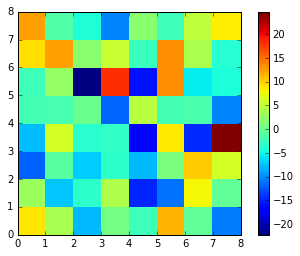

In [101]:
n = 8
SIGMA = 1.0
N = n*n
w = np.random.normal (scale=SIGMA, size=N)
K = 0.1
ALPHA = 1.0
A_2d = gen_grid_graph (n)

x_0 = np.zeros (N)
print ("x_0:", x_0)
print ("F (x_0):", F (x_0, A_2d, w, K, ALPHA))

def F_ode (x, t, A, w, k, alpha):
    return F (x, A, w, k, alpha)

t_all = [0.0, 10.0]
x_t = odeint (F_ode, x_0, t_all, args=(A_2d, w, K, ALPHA))
print ("x_t:", x_t)
plt.pcolor (np.reshape (x_t[1], (n, n)))
plt.colorbar ()
plt.axes().set_aspect('equal')

In [112]:
n = 8
SIGMA = 1.0
N = n*n
w = np.random.normal (scale=SIGMA, size=N)
print ("n:", n)
print ("w:", w)

def sim (x_0, k, alpha, t):
    t_all = np.array ([0.0, t])
    x_t = odeint (F_ode, x_0, t_all, args=(A_2d, w, k, alpha))
    return x_t[1]

def isim (k=0.0, alpha=1.0, t=0.0):
    x_t = sim (x_0, k, alpha, t)
    plt.pcolor (np.reshape (x_t, (n, n)))
    plt.colorbar ()
    plt.axes().set_aspect('equal')
    print ("(k=%g, alpha=%g, t=%g) done!" % (k, alpha, t))

n: 8
w: [-0.31014667  0.3370895  -0.70224765 -0.46452634  1.92310141 -1.10745459  0.25900398 -0.3957706
 -1.1711703  -0.56168337 -0.80427137 -0.52113255 -0.92465695 -0.31520411  1.21649965 -0.03111155
  0.2026529   0.43612836  0.21232797  0.54982596 -0.98349611 -0.28432129 -0.36573376  0.82750223
  0.39204233  2.14929659 -1.16822689  1.62454299 -0.44378027 -0.52462844 -0.43902973  0.57022587
 -0.07433925  0.90958216 -0.91866888  1.10773503  0.52248929 -1.13732173 -0.0394734   0.36332326
  1.46580357  0.16983132  0.17970685 -0.21257352  0.78254293 -1.5046825   2.95151545 -0.81238702
 -0.18025301  0.8915829  -0.31388927  1.28883393  0.40935706 -0.56926195 -0.50849959 -1.06991556
  1.03444708  1.00589212 -0.68305466 -0.2401785   0.47490714 -0.02750172 -0.13652986  2.09015586]


(k=10, alpha=1, t=10) done!


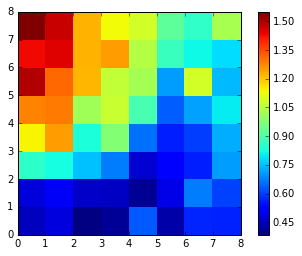

In [113]:
from ipywidgets import interact
interact (isim, k=(0.0, 10.0, 1.0), alpha=(0.1, 1.0, 0.1), t=(0.0, 10.0, 1.0)) ;

**Exercise.** What do you observe as `k` increases from `0` to `10`?